* DOMAIN: Face recognition
* CONTEXT: Company X intends to build a face identification model to recognise human faces.
* DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
* PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library.

We will be making use of PCA+SVM to implement face authorization model and sklearn's pairwise to check for similarities

### Preparing Environment -- Importing and installing necessary libraries

In [1]:
!pip install tqdm --quiet
!pip install mtcnn --quiet
!pip install keras_vggface --quiet
!pip install keras_applications --quiet

     |████████████████████████████████| 2.3MB 6.6MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 


In [2]:
import os
import zipfile
import cv2
from glob import glob
from tqdm import tqdm
from google.colab import drive
from google.colab.patches import cv2_imshow

import numpy as np
import pandas as pd
from PIL import Image
from mtcnn import MTCNN
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

Tensorflow libraries

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import metrics


### Mount drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extracting data from the given archive format

In [5]:
#to be run only once
#path_to_zip_file = '/content/drive/MyDrive/glearn/ACV/project-2/PINS Aligned Face Dataset from Pinterest.zip'
#directory_to_extract_to = '/content/drive/MyDrive/glearn/ACV/project-2'

In [6]:
!pwd

/content


In [7]:
os.chdir('/content/drive/MyDrive/glearn/ACV/project-2/pins/PINS')
!pwd

/content/drive/MyDrive/glearn/ACV/project-2/pins/PINS


In [8]:
ls

'pins_Aaron Paul'/                'pins_Josh Radnor'/
'pins_alexandra daddario'/        'pins_kiernan shipka '/
'pins_Alvaro Morte'/              'pins_Kit Harington'/
'pins_alycia debnam carey face'/  'pins_kristen stewart face'/
'pins_Amanda Crew'/               'pins_Krysten Ritter'/
'pins_Amaury Nolasco'/            'pins_Kumail Nanjiani'/
'pins_amber heard face'/          'pins_lindsey morgan face'/
'pins_Anna Gunn'/                 'pins_Maisie Williams'/
'pins_anne hathaway'/             'pins_margot robbie face'/
'pins_barbara palvin face'/       'pins_maria pedraza'/
'pins_bellamy blake face'/        'pins_Mark Ruffalo'/
'pins_Benedict Cumberbatch'/      'pins_mark zuckerberg'/
'pins_Betsy Brandt'/              'pins_Martin Starr'/
'pins_bill gates'/                'pins_Melissa benoit'/
'pins_Brenton Thwaites'/          'pins_miguel herran'/
'pins_brie larson'/               'pins_Mike Colter'/
'pins_Brit Marling'/              'pins_millie bobby brown'/
'pins_Bryan Cranston'

In [9]:
ls -ltr | wc -l #there are 101 pins folder for our dataset

101


### Splitting the data into train and test sets

In [10]:
batch_size=32
IMG_SHAPE=(224, 224, 3)
IMG_SIZE = 224
DATASET_PATH = '/content/drive/MyDrive/glearn/ACV/project-2/pins/PINS/'

In [11]:
# function to load image and return a BGR ordered image
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [12]:
print(DATASET_PATH)

/content/drive/MyDrive/glearn/ACV/project-2/pins/PINS/


In [13]:
dir_list = os.listdir()

In [14]:
column_names = ["imagepath","labels"]
dataDir = []
currentDir  = []
df = pd.DataFrame(columns = column_names)
string = ""
classes = []
pinLabel = []

for dirName in dir_list:
  os.chdir(DATASET_PATH + dirName)
  currentDir = os.listdir()
  for fileName in currentDir:
    ext = os.path.splitext(fileName)[1]
    if ext == '.jpg' or ext == '.jpeg':
      #print(fileName)
      dataDir.append(DATASET_PATH + dirName +"/" + fileName)
      classes.append(dirName.replace('pins_',""))


df['imagepath'] = dataDir
df['labels'] = classes

In [15]:
df.head()

,imagepath,labels
0,/content/drive/MyDrive/glearn/ACV/project-2/pi...,Aaron Paul
1,/content/drive/MyDrive/glearn/ACV/project-2/pi...,Aaron Paul
2,/content/drive/MyDrive/glearn/ACV/project-2/pi...,Aaron Paul
3,/content/drive/MyDrive/glearn/ACV/project-2/pi...,Aaron Paul
4,/content/drive/MyDrive/glearn/ACV/project-2/pi...,Aaron Paul


In [16]:
# Creating a label dictionary in order to map the names to an integer
print(df['labels'])
label_dict = {K: V for V, K in enumerate(df['labels'])}
print(label_dict)

0        Aaron Paul
1        Aaron Paul
2        Aaron Paul
3        Aaron Paul
4        Aaron Paul
            ...    
10765       zendaya
10766       zendaya
10767       zendaya
10768       zendaya
10769       zendaya
Name: labels, Length: 10770, dtype: object
{'Aaron Paul': 85, 'Alvaro Morte': 176, 'Amanda Crew': 294, 'Amaury Nolasco': 407, 'Anna Gunn': 473, 'Benedict Cumberbatch': 554, 'Betsy Brandt': 622, 'Brenton Thwaites': 752, 'Brit Marling': 874, 'Bryan Cranston': 954, 'Caity Lotz': 1077, 'Cameron Monaghan': 1189, 'Chance Perdomo': 1275, 'Chris Evans': 1363, 'Chris Pratt': 1504, 'Cobie Smulders': 1634, 'Danielle Panabaker': 1749, 'Dave Franco': 1875, 'Dominic Purcell': 1982, 'Dwayne Johnson': 2106, 'Emilia Clarke': 2260, 'Emily Bett Rickards': 2336, 'Emma Stone': 2464, 'Gwyneth Paltrow': 2585, 'Henry Cavil': 2719, 'Jason Momoa': 2852, 'Jeremy Renner': 2971, 'Jesse Eisenberg': 3064, 'Jim Parsons': 3173, 'Jon Bernthal': 3234, 'Josh Radnor': 3335, 'Kit Harington': 3440, 'Krysten 

In [17]:
df.shape

(10770, 2)

Split the train and test datasets

### Check samples of metadata

/content/drive/MyDrive/glearn/ACV/project-2/pins/PINS/pins_Dave Franco/Dave Franco39_1461.jpg
Dave Franco


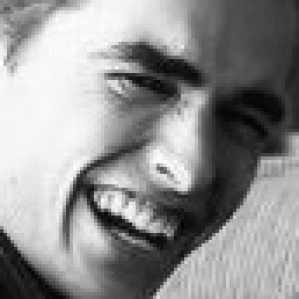

In [18]:
# Looking at a random sample image from training dataset
pic_no = np.random.randint(0, df.shape[0])
img_path = df['imagepath'][pic_no]
print(img_path)

# use the created array to output your multiple images
print(df['labels'][pic_no])
image1 = tf.keras.preprocessing.image.load_img(img_path)
image1

alexandra daddario


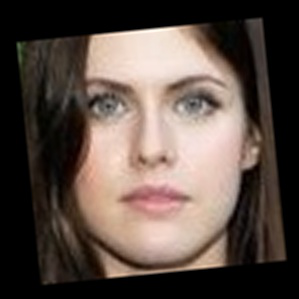

In [19]:
pic_2 = np.random.randint(0, df.shape[0])
img_path_2 = df['imagepath'][pic_2]
# use the created array to output your multiple images
print(df['labels'][pic_2])
image2 = tf.keras.preprocessing.image.load_img(img_path_2)
image2

### Load the pre-trained model and weights

In [20]:
tf.keras.backend.clear_session()
model = tf.keras.applications.ResNet50(include_top=True, #Do not include FC layer at the end
                                       input_shape=(224, 224, 3),
                                       weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [21]:
for layer in model.layers:
    layer.trainable = False

In [22]:
model.output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [23]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
pretrained_model = Model(inputs = model.layers[0].input,outputs = model.layers[-2].output)

In [25]:
print(len(pretrained_model.layers))

176


### Generate Embedding vectors for each face in the dataset

In [26]:
embeddings = []
for i in range(len(df.imagepath)):
    path = df['imagepath'][i]
    image = load_image(path)
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings.append(pretrained_model.predict(np.expand_dims(image, axis = 0))[0])
    print(i)

Streaming output truncated to the last 5000 lines.
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959

In [27]:
# For running again we can load the embeddings from this file
#embeddings = pd.read_csv('/content/drive/MyDrive/glearn/ACV/project-2/FaceEmbeddings.csv')

In [28]:
len(embeddings)

10770

In [29]:
face_embeddings = pd.DataFrame(embeddings)

In [30]:
face_embeddings.to_csv('/content/drive/MyDrive/glearn/ACV/project-2/FaceEmbeddings.csv')

## Build distance metrics for identifying the distance between two given images.

In [31]:
from tensorflow.keras import metrics
from sklearn.metrics.pairwise import euclidean_distances

In [32]:
#finding the euclidean distance between the two image embeddings
def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1 - emb2)))

In [33]:
def show_pair(n1, n2):
    plt.figure(figsize = (8, 3))
    
    plt.suptitle(f'Distance = {distance(embeddings[n1], embeddings[n2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(df['imagepath'][n1]))
    plt.subplot(122)
    plt.imshow(load_image(df['imagepath'][n2]))

In [34]:
def show_pair_cosine(idx1, idx2):
    plt.figure(figsize = (8, 3))
    cosine_similarity = metrics.CosineSimilarity()
    plt.suptitle(f'Similarity = {cosine_similarity(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(df['imagepath'][idx1]))
    plt.subplot(122)
    plt.imshow(load_image(df['imagepath'][idx2]))

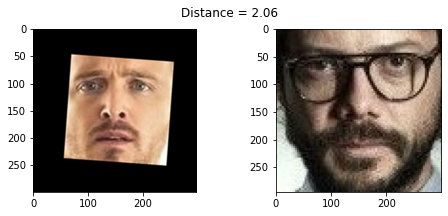

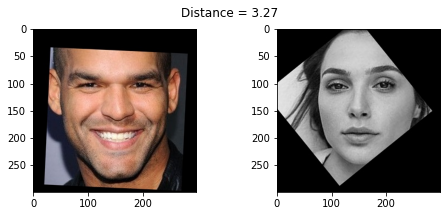

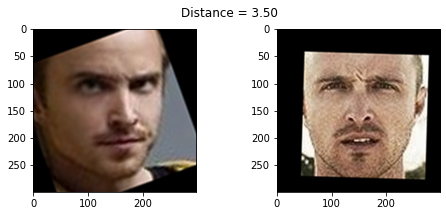

In [37]:
show_pair(10, 100)
show_pair(376, 8790)
show_pair(30,35)

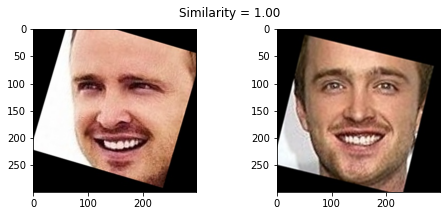

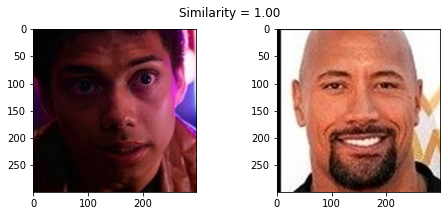

In [38]:
show_pair_cosine(5, 20)
show_pair_cosine(1200, 2000)

Splitting data into train-test

In [42]:
df['labels'].head()

0    Aaron Paul
1    Aaron Paul
2    Aaron Paul
3    Aaron Paul
4    Aaron Paul
Name: labels, dtype: object

In [68]:
#Features
X = embeddings
y = df['labels']

In [69]:
def split_data(x,y):
    index = np.random.permutation(len(x))
    x, y = np.array(x)[index], np.array(y)[index]
    print('Length of X vector : ' + str(len(x)))
    print('Length of y vector : ' + str(len(y)))
    X_train, X_test = x[:8500], x[8500:] # roughly an ~ 80% split
    y_train, y_test = y[:8500], y[8500:]

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = split_data(X, y)

display(len(X_train), len(X_test), len(y_train), len(y_test))

Length of X vector : 10770
Length of y vector : 10770


8500

2270

8500

2270

In [70]:
# Converting labels (string) into integers using label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

Use PCA for dimensionality reduction

In [71]:
# Capture 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# tranform the test data
X_test_pca = pca.transform(X_test)

### Build an SVM classifier to map each image to its right person

In [ ]:
#model = SVC(kernel='rbf', C = 100, gamma = 0.001, probability=True) --> Accuracy ~ 6 % 

In [ ]:
#model = SVC(kernel='poly', C = 10000, probability=True) --> Accuracy ~ 10 %

In [ ]:
#model = SVC(kernel='rbf', gamma = 0.0001, probability=True) --> Accuracy ~ 18%

In [ ]:
#model = SVC(kernel='rbf', C = 100000, gamma = 0.0001, probability=True) ---> Accuracy ~ 10.9%

In [80]:
model = SVC(kernel='rbf', gamma = 0.0000001, probability=True)
model.fit(X_train_pca, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [81]:
predict_result = model.predict(X_test_pca)

In [82]:
predict_result[0]

63

In [83]:
accuracy_score(y_test, predict_result)

0.018502202643171806

This is a low accuracy and can be further improved after certain number of iterations of hyper patameter tuning. Also, different pretrained models can be tried like facenet or vggface to see how things improve. 

Code references -- Pyimagesearch and machinelearningmastery.com

https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/